# Variable Importance Test

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath("../src"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from BRAT.algorithms import BRATD

## Data Generating Process

In [2]:
rng = np.random.default_rng(0)
n, d = 1000, 5
X = rng.uniform(0, 1, (n, d))
y = np.sin(2*np.pi*X[:,0]) + 0.5*X[:,1] + rng.normal(scale=1, size=n)

X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.1, random_state=0
)
d_check = 2
X_train_sub = X_train[:, :d_check]
X_hold_sub  = X_hold[:,  :d_check]

## Model Fitting

In [3]:
common = dict(
    n_estimators   = 100,
    learning_rate  = 1.0,
    max_depth      = 6,
    subsample_rate = 0.8,
    dropout_rate   = 0.8,
    disable_tqdm   = False,
)
model_full = BRATD(**common)
model_full.fit(X_train,    y_train, X_hold,    y_hold)

model_sub = BRATD(**common)
model_sub.fit(X_train_sub, y_train, X_hold_sub, y_hold)

Building BRATD trees: 100%|██████████| 100/100 [00:02<00:00, 46.84it/s]


[1.4464574582835485,
 1.3464828841600371,
 1.1833568392082505,
 1.1466684244639778,
 1.0727482010942442,
 1.0617200034834087,
 1.046926495204276,
 1.0455525441535798,
 1.0477149173829148,
 1.0388746754676796,
 1.0351860442603322,
 1.0385198133745006,
 1.064942101186553,
 1.0682184975608617,
 1.068483770245649,
 1.0635705921644876,
 1.0672409157257774,
 1.0905133061193635,
 1.0914797794538498,
 1.0941095801810272,
 1.1034156836091966,
 1.1083096396743892,
 1.1044643727539354,
 1.1016663202326458,
 1.1027686497981655,
 1.093500070243099,
 1.0988344227880384,
 1.1031036323090953,
 1.0937387787059003,
 1.0938414593649728,
 1.0914300632788816,
 1.0934747930408562,
 1.0921581739740294,
 1.0978898085718516,
 1.0975456292438435,
 1.0893839443160644,
 1.0888445748702522,
 1.0929379622966886,
 1.093873879960964,
 1.0936735122439465,
 1.092283712654462,
 1.0900287321280762,
 1.0902584318273911,
 1.0877711986460776,
 1.0874982033058582,
 1.0879654671638375,
 1.0900082632761139,
 1.0939204013124615

## The Difference Vectors

In [4]:
model_full.full_K()
model_sub .full_K()

m_pts = X_hold.shape[0]
n_train = X_train.shape[0]

R_full = np.zeros((m_pts, n_train))
R_sub  = np.zeros((m_pts, n_train))

for j, x in tqdm(enumerate(X_hold), desc = "Sketching R_full, R_sub", total=m_pts):
    rn_full, _ = model_full.sketch_r(x, vector=True)
    rn_sub,  _ = model_sub .sketch_r(x[:d_check], vector=True)
    R_full[j, :] = rn_full
    R_sub [j, :] = rn_sub

R_diff = R_full - R_sub  # shape: m*n

Sketching R_full, R_sub: 100%|██████████| 100/100 [10:37<00:00,  6.37s/it]


## Estimating Noise Variance

In [5]:
full_sigma2 = model_full.est_sigma_hat2(in_bag=False)
sub_sigma2  = model_sub.est_sigma_hat2(in_bag=False)
sigma2 = (full_sigma2 + sub_sigma2) / 2

## VCV matrix calculation

In [6]:
Sigma = sigma2 * (R_diff @ R_diff.T)
Sigma += 1e-8 * np.eye(m_pts)      # numerical ridge
Sigma_inv = np.linalg.inv(Sigma)

## Test Statistics

In [7]:
delta = model_full.predict(X_hold) - model_sub.predict(X_hold_sub)  # m-vector
T = float(delta.T @ Sigma_inv @ delta)
p_val = 1 - chi2.cdf(T, df=m_pts)

print("==============================================")
print(f"Chi2 test (m = {m_pts} test points)")
print(f"  Test statistic     T = {T:.3f}")
print(f"  Degrees of freedom    = {m_pts}")
print(f"  sigma_hat2               = {sigma2:.4e}")
print(f"  p-value               = {p_val:.4g}")
print("  Decision (alpha=0.05):", "REJECT" if p_val < 0.05 else "FAIL TO REJECT")
print("==============================================")

Chi2 test (m = 100 test points)
  Test statistic     T = 445.998
  Degrees of freedom    = 100
  sigma_hat2               = 1.1013e+00
  p-value               = 0
  Decision (alpha=0.05): REJECT


# Type I, II Error

In [8]:
rng = np.random.default_rng(66)
def run_test(n, weight_third=0.0, d=5, m_hold_pct=0.1, **common):
    """
    Runs the variable importance test for one dataset of size n.
    weight_third: signal weight for the third covariate (null=0, alternative>0).
    Returns p-value.
    """
    X = rng.uniform(0, 5, (n, d))
    # Generate y with optional signal in X[:,2]
    y = (4 * X[:,0]
        - X[:,1]**2
        + weight_third * (X[:,2])
        + rng.normal(scale=0.01, size=n)
        )

    
    # Train/hold split
    X_train, X_hold, y_train, y_hold = train_test_split(
        X, y, test_size=m_hold_pct, random_state=0
    )
    d_check = 2
    X_train_sub = X_train[:, :d_check]
    X_hold_sub  = X_hold[:,  :d_check]
    
    # Fit full and sub models
    model_full = BRATD(**common)
    model_full.fit(X_train, y_train, X_hold, y_hold)
    model_sub = BRATD(**common)
    model_sub.fit(X_train_sub, y_train, X_hold_sub, y_hold)
    
    # Build R matrices
    model_full.full_K()
    model_sub.full_K()
    m_pts = X_hold.shape[0]
    n_train = X_train.shape[0]
    
    R_full = np.zeros((m_pts, n_train))
    R_sub  = np.zeros((m_pts, n_train))
    for j, x in enumerate(X_hold):
        rn_full, _ = model_full.sketch_r(x, vector=True)
        rn_sub,  _ = model_sub.sketch_r(x[:d_check], vector=True)
        R_full[j, :] = rn_full
        R_sub [j, :] = rn_sub
    
    R_diff = R_full - R_sub
    full_sigma2 = model_full.est_sigma_hat2(in_bag=False)
    sigma2 = full_sigma2
    
    Sigma = sigma2 * (R_diff @ R_diff.T)
    Sigma_inv = np.linalg.pinv(Sigma)
    
    delta = model_full.predict(X_hold) - model_sub.predict(X_hold_sub)
    T = float(delta.T @ Sigma_inv @ delta)
    p_val = 1 - chi2.cdf(T, df=m_pts)
    return R_diff, sigma2, Sigma, Sigma_inv, T, p_val

Type II at n=20: 100%|██████████| 30/30 [02:03<00:00,  4.13s/it]


R_diff under null:       -0.000 ± 0.161
sigma2 under null:       96.514 ± 89.902
T-statistic under null:  0.509 ± 0.519
R_diff under alt:        0.000 ± 0.188
sigma2 under alt:        249.033 ± 271.113
T-statistic under alt:   52.469 ± 269.063
Type I error at n=20: 0.000
Test statistic under null: (0.3377381103371066, 0.48696022639056785, 0.020570675549888118, 0.10972753650201317, 0.5257164187069728, 0.6159933989514949, 0.3336750678707323, 0.9238729721501525, 0.1850862942655301, 0.4270794432298258, 0.09857278072899364, 0.846847740700813, 0.08990415759660775, 0.3453558427621142, 2.3887279431357267, 1.6586345006091348, 0.28682171404805773, 0.028463301574949848, 0.7072068979203388, 0.8292987018580963, 0.38550882069014464, 1.194285097546351, 0.9017990512475457, 0.26317732186532833, 0.6493580467226538, 0.31390282984186285, 0.027783598127393838, 0.27336010515359477, 0.001431093612232794, 0.007736382224931242)
Type II error at n=20: 0.900
Test statistic under alternative: (1.1524302865533662,

Type II at n=30: 100%|██████████| 30/30 [02:10<00:00,  4.35s/it]


R_diff under null:       -0.000 ± 0.124
sigma2 under null:       49.463 ± 52.637
T-statistic under null:  2.577 ± 5.443
R_diff under alt:        0.000 ± 0.175
sigma2 under alt:        93.475 ± 64.941
T-statistic under alt:   3.283 ± 3.830
Type I error at n=30: 0.100
Test statistic under null: (0.6547659856700493, 0.41982490532105315, 0.45511339365407893, 26.431889032594597, 0.6429589995907927, 0.10552985745369103, 1.2095400878477016, 0.2395856548918124, 0.9382509043213827, 0.30411483377555804, 0.1821648341996703, 0.3348594663559309, 0.10333131351996748, 3.0045338304054394, 0.7514035772609355, 0.2637492772707225, 0.2505108454391067, 0.2356223716765298, 1.3841234095435404, 0.1899637166792121, 0.5669164316786595, 2.403111974016596, 0.9890212249567937, 1.2650205218820483, 13.25172847126184, 12.888571515548712, 1.1759603627841058, 0.0668359823762661, 3.644607828930647, 2.945964357017999)
Type II error at n=30: 0.900
Test statistic under alternative: (3.7017663292553133, 0.7551731916162697, 

Type II at n=50: 100%|██████████| 30/30 [03:09<00:00,  6.30s/it]


R_diff under null:       0.000 ± 0.097
sigma2 under null:       20.935 ± 16.933
T-statistic under null:  2.032 ± 2.390
R_diff under alt:        -0.000 ± 0.140
sigma2 under alt:        67.565 ± 45.692
T-statistic under alt:   16.716 ± 26.149
Type I error at n=50: 0.033
Test statistic under null: (1.7080781515608905, 1.825184383896835, 1.1297107429932567, 0.7109708357700456, 1.1387988810502616, 0.41377926795629266, 0.20044971111440257, 0.2235514299565468, 0.6560522027392696, 0.8354823261446187, 11.576002249053317, 2.907880091084321, 5.293337216485853, 1.1543399676555635, 0.7250749622100762, 2.0348572929861324, 0.49254104170259344, 1.3982333893041545, 1.1973565213810895, 0.9709714715410765, 7.307082392506304, 3.604594381230632, 0.22445597651124358, 1.31115090663483, 2.66224998553142, 0.4129583555508503, 3.565464338155992, 3.723598830238712, 0.4686493890436199, 1.083613119976661)
Type II error at n=50: 0.700
Test statistic under alternative: (5.455478157302748, 4.184468683799138, 5.5827131

Type II at n=80: 100%|██████████| 30/30 [05:38<00:00, 11.29s/it]


R_diff under null:       0.000 ± 0.075
sigma2 under null:       9.345 ± 8.887
T-statistic under null:  4.515 ± 4.417
R_diff under alt:        -0.000 ± 0.111
sigma2 under alt:        49.866 ± 28.919
T-statistic under alt:   21.903 ± 14.785
Type I error at n=80: 0.033
Test statistic under null: (5.896718950392613, 2.4701617531374884, 4.567754332990786, 9.618146762684779, 24.669578815097516, 5.147107075857308, 1.60643792202481, 8.474679191064219, 1.8316867975504834, 5.143929208458825, 5.123212467277197, 5.7054975519600895, 4.163993423369435, 8.222149984750109, 1.1388317283168559, 0.755796639818026, 4.960977396572868, 6.127979793951516, 1.5518989879682454, 1.20431061559719, 3.411168639092079, 0.865580853664355, 1.8589936939363836, 4.72415511678525, 3.243772246947646, 2.9827186732170574, 2.0159361506528795, 5.086028592228493, 1.5095837784500832, 1.3658026987325407)
Type II error at n=80: 0.433
Test statistic under alternative: (42.386790675516465, 31.32701037457389, 26.083045626003937, 44.8

Type II at n=100: 100%|██████████| 30/30 [06:25<00:00, 12.86s/it]


R_diff under null:       -0.000 ± 0.065
sigma2 under null:       8.789 ± 5.783
T-statistic under null:  4.455 ± 3.945
R_diff under alt:        -0.000 ± 0.096
sigma2 under alt:        39.215 ± 24.013
T-statistic under alt:   45.153 ± 39.998
Type I error at n=100: 0.000
Test statistic under null: (1.3724555445534394, 8.710462680516336, 1.8651291629913778, 1.1730515278752378, 10.001364832230719, 2.0896325919347367, 2.0769112624727, 2.4780213895381817, 2.9556028389767888, 5.604840252195058, 4.031558676255876, 2.5142252958991334, 2.886680652938644, 2.2783567213660962, 2.2005696470713163, 2.6281939989705005, 0.6628760196836415, 6.013878924018828, 6.9321883413135845, 3.3726602587832084, 1.373625134239923, 9.796582648805275, 2.737379622597514, 1.2428702615677267, 4.224520751532121, 1.584976200265423, 14.577334993836164, 2.5974065222289187, 6.634779675304805, 17.035608551892093)
Type II error at n=100: 0.200
Test statistic under alternative: (117.28711771207408, 114.02909072616674, 27.506514640

Type II at n=200: 100%|██████████| 30/30 [10:29<00:00, 20.98s/it]


R_diff under null:       -0.000 ± 0.042
sigma2 under null:       4.510 ± 1.917
T-statistic under null:  14.618 ± 21.034
R_diff under alt:        0.000 ± 0.062
sigma2 under alt:        18.630 ± 6.011
T-statistic under alt:   161.199 ± 69.213
Type I error at n=200: 0.067
Test statistic under null: (5.135988884871345, 5.251827524538758, 23.77174935976591, 5.642583741601294, 10.737524051882444, 6.613433713991807, 6.3751329588729355, 19.743030781902842, 8.850094178600049, 11.280406011765013, 5.7261606090829265, 2.3439443605274617, 7.21299499909734, 10.475377946639835, 10.406537169620197, 2.5268828649723005, 29.56012075456581, 4.250989013256056, 14.203525914116106, 15.161532793063682, 6.7680645517244455, 12.967386181580688, 3.060624395073728, 118.05717506584446, 6.658995960458153, 28.28172861497518, 4.798466573765745, 4.426766361019338, 10.189086011833533, 38.05257152453323)
Type II error at n=200: 0.000
Test statistic under alternative: (303.45039153007735, 186.77772474699037, 359.521196449

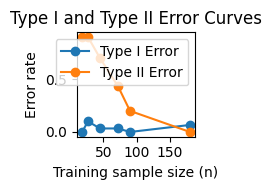

In [9]:
# Simulation settings
n_list = [20, 30, 50, 80, 100, 200]
train_n_list = [n * 0.9 for n in n_list]

reps = 30
common_params = dict(
    n_estimators   = 100,
    learning_rate  = 1.0,
    max_depth      = 8,
    subsample_rate = 1.0,
    dropout_rate   = 0.95,
    disable_tqdm   = True,
)

type1_errors = []
type2_errors = []

for n in n_list:
    results_null = [run_test(n, weight_third=0.0, **common_params) for _ in tqdm(range(reps), desc=f"Type I at n={n}")]
    results_alt  = [run_test(n, weight_third=5.0, **common_params) for _ in tqdm(range(reps), desc=f"Type II at n={n}")]
    R_diffs_null, sigma2s_null, Sigmas_null, Sigmas_inv_null, T_nulls, pvals_nulls = zip(*results_null)
    R_diffs_alt, sigma2s_alt, Sigmas_alt, Sigmas_inv_alt, T_alts, pvals_alts = zip(*results_alt)
    
    # summaries under null
    rdn = np.array(R_diffs_null)         # shape (reps, m_hold, n_train)
    s2n = np.array(sigma2s_null)         # shape (reps,)
    Tin = np.array(T_nulls)              # shape (reps,)

    print(f"R_diff under null:       {rdn.mean():.3f} ± {rdn.std():.3f}")
    print(f"sigma2 under null:       {s2n.mean():.3f} ± {s2n.std():.3f}")
    print(f"T-statistic under null:  {Tin.mean():.3f} ± {Tin.std():.3f}")

    # summaries under alt
    rda = np.array(R_diffs_alt)
    s2a = np.array(sigma2s_alt)
    Tia = np.array(T_alts)

    print(f"R_diff under alt:        {rda.mean():.3f} ± {rda.std():.3f}")
    print(f"sigma2 under alt:        {s2a.mean():.3f} ± {s2a.std():.3f}")
    print(f"T-statistic under alt:   {Tia.mean():.3f} ± {Tia.std():.3f}")

    # Type I error (false positive rate under null)
    type1_errors.append(np.mean(np.array(pvals_nulls) < 0.05))
    # Type II error (false negative rate under alternative)
    type2_errors.append(np.mean(np.array(pvals_alts) >= 0.05))
    print(f"Type I error at n={n}: {type1_errors[-1]:.3f}")
    print('Test statistic under null:', T_nulls)
    print(f"Type II error at n={n}: {type2_errors[-1]:.3f}")
    print('Test statistic under alternative:', T_alts)

out_dir = './variable_importance/'
os.makedirs(out_dir, exist_ok=True)

results = pd.DataFrame({
    'n':            train_n_list,
    'type_I_error': type1_errors,
    'type_II_error': type2_errors
})

results.to_csv(os.path.join(out_dir, 'size_and_power.csv'), index=False)
print(f"Saved summary to {os.path.join(out_dir, 'size_and_power.csv')}")

# Plotting
plt.figure(figsize=(2, 2))
plt.plot(train_n_list, type1_errors, marker='o', label='Type I Error')
plt.plot(train_n_list, type2_errors, marker='o', label='Type II Error')
plt.xlabel('Training sample size (n)')
plt.ylabel('Error rate')
plt.title('Type I and Type II Error Curves')
plt.legend()
plt.tight_layout()
plt.show()
